# Sample Connect4
This connect 4 code was provided by Professor Dan. It uses a 6x7 board.

In [32]:
import numpy as np
from IPython.display import clear_output
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
# https://www.youtube.com/watch?v=UXW2yZndl7U

In [17]:
def update_board(board_temp,color,column):
    # this is a function that takes the current board status, a color, and a column and outputs the new board status
    # columns 0 - 6 are for putting a checker on the board: if column is full just return the current board...this should be forbidden by the player
    
    # the color input should be either 'plus' or 'minus'
    
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]
    
    # this seems silly, but actually faster to run than using sum because of overhead! 
    colsum = abs(board[0,column])+abs(board[1,column])+abs(board[2,column])+abs(board[3,column])+abs(board[4,column])+abs(board[5,column])
    row = int(5-colsum)
    if row > -0.5:
        if color == 'plus':
            board[row,column] = 1
        else:
            board[row,column] = -1
    return board
    
# in this code the board is a 6x7 numpy array.  Each entry is +1, -1 or 0.  You WILL be able to do a better
# job training your neural network if you rearrange this to be a 6x7x2 numpy array.  If the i'th row and j'th
# column is +1, this can be represented by board[i,j,0]=1.  If it is -1, this can be represented by
# board[i,j,1]=1. It's up to you how you represent your board.


In [18]:
board = np.zeros((6,7))
board = update_board(board,'plus',3)
board = update_board(board,'minus',3)
board = update_board(board,'plus',3)
board = update_board(board,'minus',3)
board = update_board(board,'plus',3)
board = update_board(board,'minus',3)
print(board)
board = update_board(board,'plus',3)
print(board)

[[ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]
[[ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]


In [19]:
def check_for_win_slow(board):
    # this function checks to see if anyone has won on the given board
    nrow = board.shape[0]
    ncol = board.shape[1]
    winner = 'nobody'
    for col in range(ncol):
        for row in reversed(range(nrow)):
            if abs(board[row,col]) < 0.1: # if this cell is empty, all the cells above it are too!
                break
            # check for vertical winners
            if row <= (nrow-4): # can't have a column go from rows 4-7...
                tempsum = board[row,col]+board[row+1,col]+board[row+2,col]+board[row+3,col] # this is WAY faster than np.sum!!!
                if tempsum==4:
                    winner = 'v-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'v-minus'
                    return winner
            # check for horizontal winners
            if col <= (ncol-4):
                tempsum = board[row,col]+board[row,col+1]+board[row,col+2]+board[row,col+3]
                if tempsum==4:
                    winner = 'h-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'h-minus'
                    return winner
            # check for top left to bottom right diagonal winners
            if (row <= (nrow-4)) and (col <= (ncol-4)):
                tempsum = board[row,col]+board[row+1,col+1]+board[row+2,col+2]+board[row+3,col+3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
            # check for top right to bottom left diagonal winners
            if (row <= (nrow-4)) and (col >= 3):
                tempsum = board[row,col]+board[row+1,col-1]+board[row+2,col-2]+board[row+3,col-3]
                if tempsum==4:
                    winner = 'd-plus'
                    return winner
                elif tempsum==-4:
                    winner = 'd-minus'
                    return winner
    return winner

In [20]:
def check_for_win(board,col):
    # this code is faster than the above code, but it requires knowing where the last checker was dropped
    # it may seem extreme, but in MCTS this function is called more than anything and actually makes up
    # a large portion of total time spent finding a good move.  So every microsecond is worth saving!
    nrow = 6
    ncol = 7
    # take advantage of knowing what column was last played in...need to check way fewer possibilities
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-plus'
        elif vert == -4:
            return 'v-minus'
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-plus'
        elif hor == -4:
            return 'h-minus'
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-plus'
        elif DR == -4:
            return 'd-minus'
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-1 >= 0 and col+1 < 7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-2 >=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-plus'
        elif DL == -4:
            return 'd-minus'
    return 'nobody'

In [21]:
def find_legal(board):
    legal = [i for i in range(7) if abs(board[0,i]) < 0.1]
    return legal

In [22]:
def look_for_win(board_,color):
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
            winner = m
            break
    return winner

In [23]:
def find_all_nonlosers(board,color):
    if color == 'plus':
        opp = 'minus'
    else:
        opp = 'plus'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    allowed = []
    for i in range(len(legal)):
        wins = [j for j in poss_legal[i] if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

In [24]:
def back_prop(winner,path,color0,md):
    for i in range(len(path)):
        board_temp = path[i]
        
        md[board_temp][0]+=1
        if winner[2]==color0[0]:
            if i % 2 == 1:
                md[board_temp][1] += 1
            else:
                md[board_temp][1] -= 1
        elif winner[2]=='e': # tie
            # md[board_temp][1] += 0
            pass
        else:
            if i % 2 == 1:
                md[board_temp][1] -= 1
            else:
                md[board_temp][1] += 1

In [25]:
def rollout(board,next_player):
    winner = 'nobody'
    player = next_player
    while winner == 'nobody':
        legal = find_legal(board)
        if len(legal) == 0:
            winner = 'tie'
            return winner
        move = random.choice(legal)
        board = update_board(board,player,move)
        winner = check_for_win(board,move)
        
        if player == 'plus':
            player = 'minus'
        else:
            player = 'plus'
    return winner
        

In [26]:
def mcts(board_temp,color0,nsteps):
    # nsteps is a parameter that determines the skill (and slowness) of the player
    # bigger values of nsteps means the player is better, but also slower to figure out a move.
    board = board_temp.copy()
    ##############################################
    winColumn = look_for_win(board,color0) # check to find a winning column
    if winColumn > -0.5:
        return winColumn # if there is one - play that!
    legal0 = find_all_nonlosers(board,color0) # find all moves that won't immediately lead to your opponent winning
    if len(legal0) == 0: # if you can't block your opponent - just find the 'best' losing move
        legal0 = find_legal(board)
    ##############################################
    # the code above, in between the hash rows, is not part of traditional MCTS
    # but it makes it better and faster - so I included it!
    # MCTS occasionally makes stupid mistakes
    # like not dropping the checker on a winning column, or not blocking an obvious opponent win
    # this avoids a little bit of that stupidity!
    # we could also add this logic to the rest of the MCTS and rollout functions - I just haven't done that yet...
    # feel free to experiment!
    mcts_dict = {tuple(board.ravel()):[0,0]}
    for ijk in range(nsteps):
        color = color0
        winner = 'nobody'
        board_mcts = board.copy()
        path = [tuple(board_mcts.ravel())]
        while winner == 'nobody':
            legal = find_legal(board_mcts)
            if len(legal) == 0:
                winner = 'tie'
                back_prop(winner,path,color0,mcts_dict)
                break
            board_list = []
            for col in legal:
                board_list.append(tuple(update_board(board_mcts,color,col).ravel()))
            for bl in board_list:
                if bl not in mcts_dict.keys():
                    mcts_dict[bl] = [0,0]
            ucb1 = np.zeros(len(legal))
            for i in range(len(legal)):
                num_denom = mcts_dict[board_list[i]]
                if num_denom[0] == 0:
                    ucb1[i] = 10*nsteps
                else:
                    ucb1[i] = num_denom[1]/num_denom[0] + 2*np.sqrt(np.log(mcts_dict[path[-1]][0])/mcts_dict[board_list[i]][0])
            chosen = np.argmax(ucb1)
            
            board_mcts = update_board(board_mcts,color,legal[chosen])
            path.append(tuple(board_mcts.ravel()))
            winner = check_for_win(board_mcts,legal[chosen])
            if winner[2]==color[0]:
                back_prop(winner,path,color0,mcts_dict)
                break
            if color == 'plus':
                color = 'minus'
            else:
                color = 'plus' 
            if mcts_dict[tuple(board_mcts.ravel())][0] == 0:
                winner = rollout(board_mcts,color)
                back_prop(winner,path,color0,mcts_dict)
                break
            
    maxval = -np.inf
    best_col = -1
    for col in legal0:
        board_temp = tuple(update_board(board,color0,col).ravel())
        num_denom = mcts_dict[board_temp]
        if num_denom[0] == 0:
            compare = -np.inf
        else:
            compare = num_denom[1] / num_denom[0]
        if compare > maxval:
            maxval = compare
            best_col = col
    return (best_col)
            

In [27]:
mcts(np.zeros((6,7)),'plus',5000)

3

In [28]:
board = np.zeros((6,7))
winner = 'nobody'
color = 'plus'
while winner == 'nobody':
    if color == 'minus':
        col = mcts(board,color,300)
    else:
        col = mcts(board,color,1500)
    board = update_board(board,color,col)
    winner = check_for_win(board,col)
    if color == 'plus':
        color = 'minus'
    else:
        color = 'plus'
    print(board)
    print('=========================')
print(winner)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0. -1. -1.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0. -1. -1.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. 

In [29]:
def display_board(board):
    # this function displays the board as ascii using X for +1 and O for -1
    # For the project, this should be a better picture of the board...
    clear_output()
    horizontal_line = '-'*(7*5+8)
    blank_line = '|'+' '*5
    blank_line *= 7
    blank_line += '|'
    print('   0     1     2     3     4     5     6')
    print(horizontal_line)
    for row in range(6):
        print(blank_line)
        this_line = '|'
        for col in range(7):
            if board[row,col] == 0:
                this_line += ' '*5 + '|'
            elif board[row,col] == 1:
                this_line += '  X  |'
            else:
                this_line += '  O  |'
        print(this_line)
        print(blank_line)
        print(horizontal_line)
    print('   0     1     2     3     4     5     6')

            

In [30]:
def plot_connect4(board, ax=None):
    """
    Plots a Connect 4 board using Matplotlib.
    
    Parameters:
        board (2D numpy array): A 6x7 matrix representing the board state.
                                0 for empty, 1 for Player 1, 2 for Player 2.
        ax (matplotlib.axes): Matplotlib Axes object to plot on (optional).
    """
    rows, cols = board.shape
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    
    # Plot grid
    for row in range(rows):
        for col in range(cols):
            color = "white"  # Default empty color
            if board[row, col] == 1:
                color = "red"  # Player 1's pieces
            elif board[row, col] == 2:
                color = "yellow"  # Player 2's pieces
            
            # Draw a circle for each slot
            circle = plt.Circle((col + 0.5, rows - row - 0.5), 0.4, color=color, ec="black", lw=1)
            ax.add_patch(circle)
    
    # Configure axis
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(np.arange(cols) + 0.5, labels=np.arange(1, cols + 1))
    ax.set_yticks(np.arange(rows) + 0.5, labels=np.arange(rows, 0, -1))
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_facecolor("blue")  # Board background color
    ax.tick_params(left=False, bottom=False, labelsize=12)

    plt.show()

In [15]:
# # this is how you can play a game
# winner = 'nobody'
# board = np.zeros((6,7))

# display_board(board)

# player = 'plus'

# while winner == 'nobody':
#     move = input('Pick a move (0-6) for player '+player+': ')
#     move = int(move)
#     board = update_board(board,player,move)
#     display_board(board)
#     winner = check_for_win(board,move)
#     if player == 'plus':
#         player = 'minus'
#     else:
#         player = 'plus'
# print('The winner is '+winner)
    

   0     1     2     3     4     5     6
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
|     |     |     |     |     |     |     |
-------------------------------------------
|     |     |     |     |     |    

KeyboardInterrupt: Interrupted by user

## Play

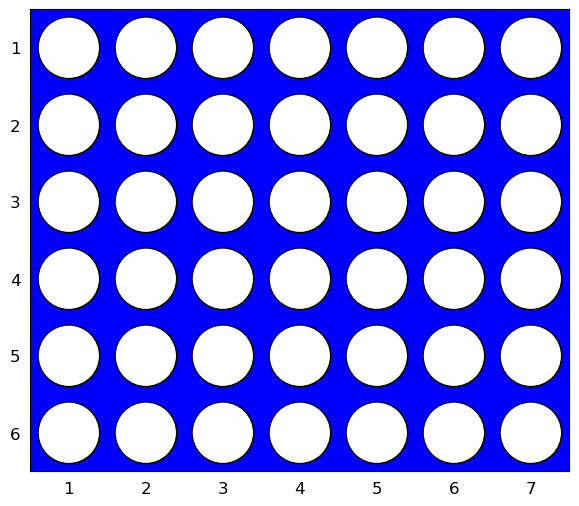

The winner is v-minus


In [33]:
# this is how you can play a game
winner = 'nobody'
board = np.zeros((6,7))
plot_connect4(board)
player = 'red'

human_player = input('Which player would you like to be? Red or yellow?')

while winner == 'nobody':
    if player == human_player:
        move = input('Pick a move (1-7) for player '+player+': ')
        move = int(move) - 1
        board = update_board(board,player,move)
        plot_connect4(board)
        clear_output()
        winner = check_for_win(board,move)
    elif player != human_player:
        col = mcts(board, color, 1500) 
        board = update_board(board,player,col)
        plot_connect4(board)
        clear_output()
        winner = check_for_win(board,move)
    if player == 'red':
        player = 'yellow'
    else:
        player = 'red'
    
print('The winner is '+winner)

In [34]:
board

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.,  0.]])